In [1]:
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import praw

user_agent = "Scraper 1.0"
reddit = praw.Reddit(
    client_id = "gscPTd0wywq_IjgqoL1Smg",
    client_secret = "UAeWcM7eWeVXQVRJLZehtFq655Dzmw",
    user_agent = user_agent
)

In [3]:
headlines = set()

for submission in reddit.subreddit('btc').hot(limit = None):
    #print(submission.title)
    #print(submission.id)
    #print(submission.author)
    #print(submission.created_utc)
    #print(submission.score)
    #print(submission.upvote_ratio)
    #print(submission.url)
    #break
    headlines.add(submission.title)
for submission in reddit.subreddit('binance').hot(limit = None):
    headlines.add(submission.title)
for submission in reddit.subreddit('coinbase').hot(limit = None):
    headlines.add(submission.title)
for submission in reddit.subreddit('bitcoin').hot(limit = None):
    headlines.add(submission.title)
print(len(headlines))


2906


In [4]:
df = pd.DataFrame(headlines)
df.head()

,0
0,"Cashout to CC, where did my money go?"
1,What would need to happen for you to start reb...
2,Why did Cointelegraph announce fake news?
3,My father is an NFT enthusiast
4,Is it true that North Korea is heavily involve...


In [5]:
df.to_csv('headlines-crypto.csv', header = False, encoding = 'utf-8', index = False)

In [6]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/albert/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [7]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
sia = SIA()
results = []
for line in headlines:
    pol_score = sia.polarity_scores(line)
    pol_score['headline'] = line
    results.append(pol_score)

pprint(results[:3], width = 100 )

[{'compound': 0.0,
  'headline': 'Cashout to CC, where did my money go?',
  'neg': 0.0,
  'neu': 1.0,
  'pos': 0.0},
 {'compound': 0.0,
  'headline': 'What would need to happen for you to start rebalancing your brokerage accounts out '
              'of stocks and into Bitcoin?',
  'neg': 0.0,
  'neu': 1.0,
  'pos': 0.0},
 {'compound': -0.4767,
  'headline': 'Why did Cointelegraph announce fake news?',
  'neg': 0.383,
  'neu': 0.617,
  'pos': 0.0}]


In [8]:
df = pd.DataFrame.from_records(results)
df.head()

,neg,neu,pos,compound,headline
0,0.000,1.000,0.000,0.0000,"Cashout to CC, where did my money go?"
1,0.000,1.000,0.000,0.0000,What would need to happen for you to start reb...
2,0.383,0.617,0.000,-0.4767,Why did Cointelegraph announce fake news?
3,0.000,0.667,0.333,0.3612,My father is an NFT enthusiast
4,0.000,0.797,0.203,0.4215,Is it true that North Korea is heavily involve...


In [9]:
df['label'] = 0 
df.loc[df['compound'] > 0.2, 'label'] = 1
df.loc[df['compound'] < 0.2, 'label'] = -1
df.loc[(0.2 > df['compound']) & (df['compound'] > -0.2), 'label'] = 0
df.head()



,neg,neu,pos,compound,headline,label
0,0.000,1.000,0.000,0.0000,"Cashout to CC, where did my money go?",0
1,0.000,1.000,0.000,0.0000,What would need to happen for you to start reb...,0
2,0.383,0.617,0.000,-0.4767,Why did Cointelegraph announce fake news?,-1
3,0.000,0.667,0.333,0.3612,My father is an NFT enthusiast,1
4,0.000,0.797,0.203,0.4215,Is it true that North Korea is heavily involve...,1


In [10]:
df2 = df[['headline', 'label']]

In [11]:
df2.to_csv('reddit_headline_labels.csv', encoding = 'utf-8', index = False)

In [12]:
df.label.value_counts()

label
 0    1757
 1     658
-1     491
Name: count, dtype: int64

In [13]:
df.label.value_counts(normalize = True) * 100

label
 0    60.461115
 1    22.642808
-1    16.896077
Name: proportion, dtype: float64

In [14]:
print("Positive headlines: \n")
pprint(list(df[df['label'] == 1].headline)[:5], width = 200)

print("\nNegative headlines: \n")
pprint(list(df[df['label'] == -1].headline)[:5], width = 200)

Positive headlines: 

['My father is an NFT enthusiast',
 'Is it true that North Korea is heavily involved in crypto theft?',
 'How Bitcoin Shifts Society + Energy in the Global South for the Better -- the Pioneer Species',
 'help plz. I sent USDT from Binance to Coinbase using MATIC network. What now?',
 'Bitcoin Cash retail centre set to expand']

Negative headlines: 

['Why did Cointelegraph announce fake news?',
 'Coinbase is a scam they charge hidden fees BEWARE DO NOT USE.',
 'Are the CoinBase giveaway real? Seems shady, especially with all the complaints',
 "We have 90 days to fight back against FinCEN's Proposed Measures",
 'Me not buying Bitcoin since 2021, ignores the dips and buys on the hype.']


/tmp/ipykernel_6489/3139448537.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Negative", "Neutral", "Positive"])


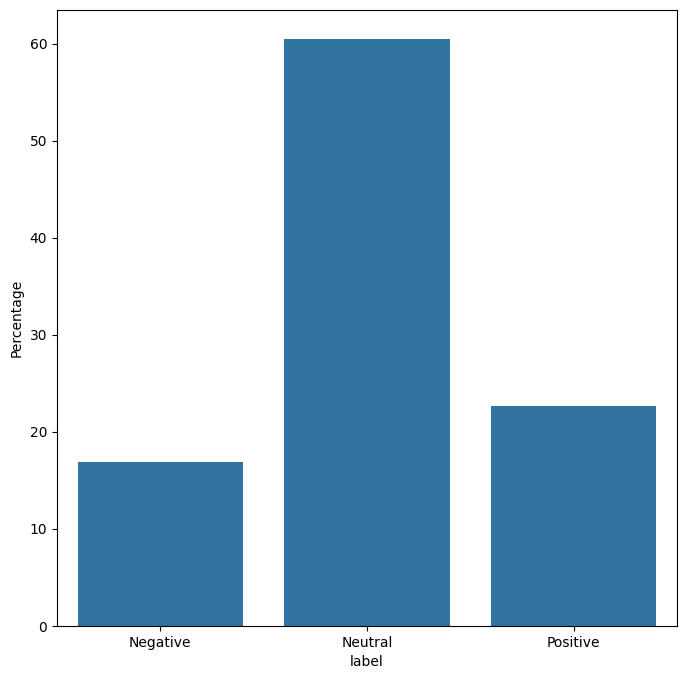

In [15]:
fig, ax = plt.subplots(figsize = (8, 8))
counts = df.label.value_counts(normalize = True)*100

sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(["Negative", "Neutral", "Positive"])
ax.set_ylabel("Percentage")
plt.show()

In [16]:
#compound score is the overall sentiment of the headline, 
#which can range from -1 to +1 with -1 being negative sentiment and +1 being positive
#final input into the ML models will be the compound score
compound = df[['compound', 'headline']]
compound.head()


,compound,headline
0,0.0000,"Cashout to CC, where did my money go?"
1,0.0000,What would need to happen for you to start reb...
2,-0.4767,Why did Cointelegraph announce fake news?
3,0.3612,My father is an NFT enthusiast
4,0.4215,Is it true that North Korea is heavily involve...


In [17]:
#average of all compound scores 
#normalized to [0,1] and expressed in percentage
mean = df["compound"].mean()
mean = ((mean+1)/2)*100
print(mean)

51.602816586373024
